In [1]:
%matplotlib inline
import os, pickle
import cv2
import matplotlib
import numpy as np
import FileIO as fio
import Camera as camsolve
from matplotlib import pyplot as plt
from matplotlib import patches as ptch
plt.style.use("ggplot")

In [29]:
def show_clicks_reporj_on_img(ax, img, clicks, reproj):
    ax.imshow(img)
    ax.plot(clicks[:, 0], clicks[:, 1], "b+", label="Ground truth")
    ax.plot(reproj[:, 0], reproj[:, 1], "rx", label="Reprojection")
    ax.legend()

In [4]:
camproj_path = "/home/liyanc/Desktop/raid/scratch2/pose/processing/staging/meta_mid/cameras/20180831_liyan_basecam_proj.pkl"
cam_proj = fio.load_pkl(camproj_path)

In [5]:
unlbl_path = "/home/liyanc/Desktop/raid/scratch2/pose/processing/staging/meta_in/calibration/20180831_liyan_static_geometry_real.pkl"
unlabeled_dict = fio.load_pkl(unlbl_path, True)

In [24]:
root_dir = "/home/liyanc/Desktop/raid/scratch2/pose/processing/staging"
kinect_subdir = "20180831/liyanc_static_geometry2"
cam = "01"

In [25]:
imgdir = "{:}/{:}".format(root_dir, kinect_subdir)
mean_img = fio.lz4_mean_img(fio.list_img_cam(imgdir, cam))
img_size = np.array(mean_img.shape[:2])
init_c = img_size / 2

In [26]:
p_world, q_proj = np.zeros([len(cam_proj[cam]), 3], np.float32), np.zeros([len(cam_proj[cam]), 2], np.float32)
for ind, pt in enumerate(cam_proj[cam].items()):
    mkr_id, proj_pt = pt
    q_proj[ind, :] = proj_pt
    p_world[ind, :] = unlabeled_dict[mkr_id]["mean"]

In [56]:
class CameraSolverNonlinear:
    def __init__(self, init_f=(1125.0, 1125.0), init_c=(500.0, 500.0), img_size=(1000, 1000)):
        self.init_f = init_f
        self.init_c = init_c
        self.img_size = img_size

    def solve(self, p_world, q_truth, iterations=300, term_epsilon=1e-3):
        f = np.random.normal(self.init_f, 40.0, [2]).astype(np.float64)
        c = np.random.normal(self.init_c, 20.0, [2]).astype(np.float64)

        init_cam = np.array([
            [f[0], 0, c[0]],
            [0, f[1], c[1]],
            [0, 0, 1]])
        flags = cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5 + \
            cv2.CALIB_FIX_K6 + cv2.CALIB_FIX_S1_S2_S3_S4
        crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iterations, term_epsilon)
        retval, cam, dist, rvecs, tvecs = cv2.calibrateCamera(
            [p_world.T.astype(np.float32)], [q_truth.T.astype(np.float32)], self.img_size, init_cam, None, flags=flags,
            criteria=crit)

        self.cam = cam
        self.dist = dist
        self.theta = rvecs[0]
        self.t = tvecs[0]

        return self.cam, self.dist, self.theta, self.t

    def projection_errs(self, p_world, q_truth):
        proj_pts, _ = cv2.projectPoints(p_world.T, self.theta, self.t, self.cam, self.dist)
        return np.sqrt(np.sum((q_truth.T - proj_pts[:, 0, :]) ** 2, axis=1))

    def undistort_pts(self, dist_p):
        undist = cv2.undistortPoints(np.expand_dims(dist_p.T, 0), self.cam, self.dist, np.identity(3), self.cam)
        return undist[0, ...]

    def undistort_img(self, img):
        undist = cv2.undistort(img, self.cam, self.dist)
        return undist

    def project_linear(self, p_world):
        proj_pts, _ = cv2.projectPoints(p_world.T, self.theta, self.t, self.cam, None)
        return proj_pts[:, 0, :]

    def camera_coordinate(self, p_world):
        R = cv2.Rodrigues(self.theta)[0]
        return np.matmul(R, p_world.T) + self.t

    def world_coordinate_by_z_imgpt(self, imgpt, z):
        R = cv2.Rodrigues(self.theta)[0]
        K = self.cam
        cam_pts = np.concatenate(
            [(imgpt - K[:2, 2]) / K.diagonal()[:2], np.ones((imgpt.shape[0], 1))], 1) * z[:, np.newaxis]
        return np.matmul(R.T, cam_pts.T - self.t).T

In [27]:
csolver = camsolve.CameraSolverNonlinear(init_f=(1032, 1032), init_c=tuple(init_c), img_size=tuple(img_size))
csolver.solve(p_world.T, q_proj.T)

(array([[1.08271342e+03, 0.00000000e+00, 9.19861792e+02],
        [0.00000000e+00, 1.08820063e+03, 5.23210780e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 0.16817949, -0.27323676, -0.00332877, -0.01598963,  0.        ]]),
 array([[-1.84016077],
        [ 0.10280852],
        [-2.55564798]]),
 array([[ 97.73218641],
        [ 98.20330351],
        [559.25597437]]))

Mean reprojection errors: 1.0547103


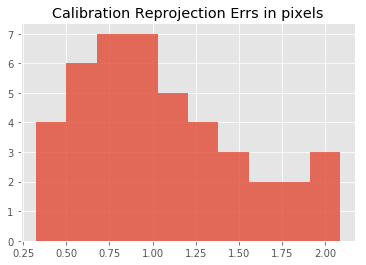

In [28]:
_ = plt.hist(csolver.projection_errs(p_world.T, q_proj.T), alpha=0.8)
_ = plt.title("Calibration Reprojection Errs in pixels")
print("Mean reprojection errors:", np.mean(csolver.projection_errs(p_world.T, q_proj.T)))

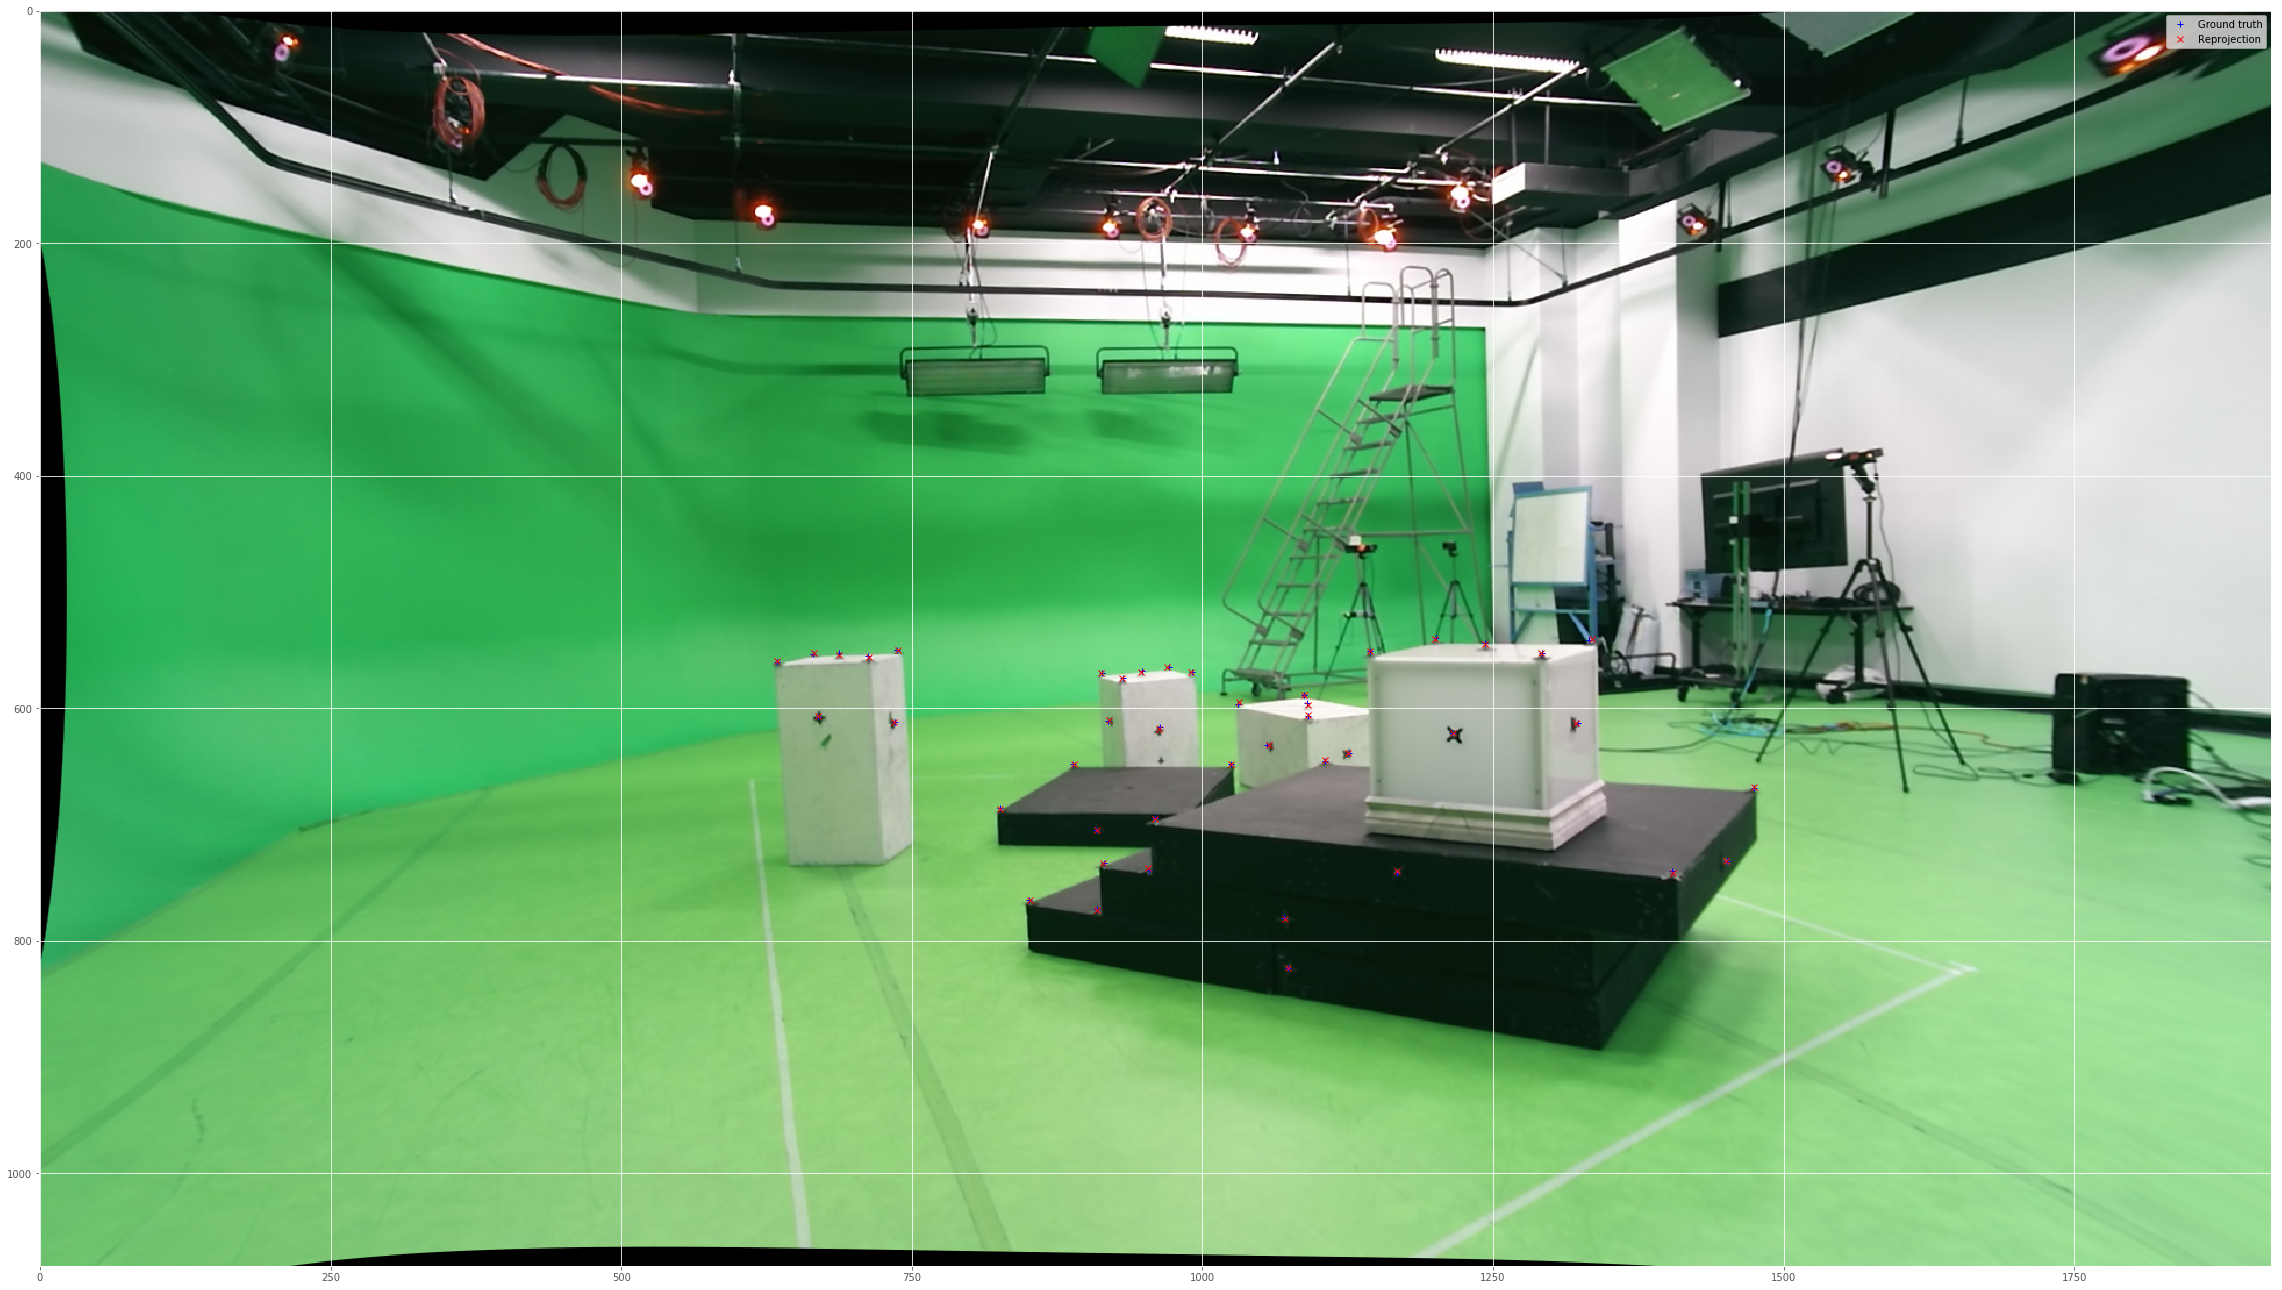

In [32]:
fig = plt.figure(figsize=(40, 24))
ax = plt.subplot(111)
linear_img = csolver.undistort_img(mean_img)
linear_pts = csolver.undistort_pts(q_proj.T)
reproj = csolver.project_linear(p_world.T)
show_clicks_reporj_on_img(ax, linear_img, linear_pts, reproj)

In [ ]:
    def __init__(self, init_f=(1125.0, 1125.0), init_c=(500.0, 500.0), img_size=(1000, 1000)):
        self.init_f = init_f
        self.init_c = init_c
        self.img_size = img_size

    def solve(self, p_world, q_truth, iterations=300, term_epsilon=1e-3):